#Task 3: Energy Consumption Time Series Forecasting

**Dataset:**

Household Power Consumption Dataset

##1. Introduction and Problem Statement

**Introduction**

Energy consumption forecasting helps predict future electricity usage based on past data. Household energy use changes over time due to daily and weekly patterns. In this task, we analyze historical data and compare ARIMA, Prophet, and XGBoost models to forecast short-term energy consumption and evaluate their performance using MAE and RMSE.

**Problem Statement**

Household electricity usage changes over time depending on hour, day, and behavior patterns. Without forecasting, energy providers cannot efficiently manage supply and demand.

**Objective**

The goal of this project is to forecast short-term household energy consumption using historical time-series data and compare three models:
- ARIMA (statistical model)
- Prophet (trend + seasonality model)
- XGBoost (machine learning model)

Evaluation metrics:

- MAE (Mean Absolute Error)
- RMSE (Root Mean Square Error)

### 2. Dataset Understanding and Description

The Household Power Consumption dataset contains time-based electricity usage readings collected from a single household over several years.

- **Total Records:** ~2 million time entries
- **Target Variable:** Global_active_power (energy consumption)

**Features Include**

- **Time information:** Date, Time
- **Electrical measurements:** Global_reactive_power, Voltage, Global_intensity
- **Appliance usage:** Sub_metering_1, Sub_metering_2, Sub_metering_3

The dataset is a time series dataset recorded at minute intervals, so datetime parsing, resampling, and temporal feature engineering are required before training forecasting models.

##3. Data Loading and Cleaning
**Import Required Libraries**



In [ ]:
# Basic libraries for data manipulation
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Time series forecasting models
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from xgboost import XGBRegressor

# Metrics for model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Ignore warnings to keep output clean
import warnings
warnings.filterwarnings('ignore')

**Dataset Loading**

In [ ]:
from google.colab import files
files.upload()

df = pd.read_csv("household_power_consumption.csv")

Saving household_power_consumption.csv to household_power_consumption.csv


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17.0
1,16/12/2006,17:25:00,5.36,0.436,233.63,23,0,1,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23,0,2,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23,0,1,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17.0


Display the first 5 rows of the DataFrame to inspect the data

In [ ]:
df.head()

**Checking Column Names**

In [ ]:
df.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

##3. Data Cleaning and Preprocessing
**Convert Date + Time into datetime**

In [ ]:
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                format='%d/%m/%Y %H:%M:%S')

df.set_index('datetime', inplace=True)
df.drop(['Date','Time'], axis=1, inplace=True)#

**Replace missing values**

In [ ]:
df.replace('?', np.nan, inplace=True)
df = df.astype(float)

# Fill missing values
df.fillna(method='ffill', inplace=True)


**Resample Time Series**

We forecast hourly usage (better for learning patterns)

In [ ]:
energy = df['Global_active_power'].resample('H').mean()
energy = energy.dropna()


##4. Exploratory Data Analysis (EDA)
**Plot Energy Usage**

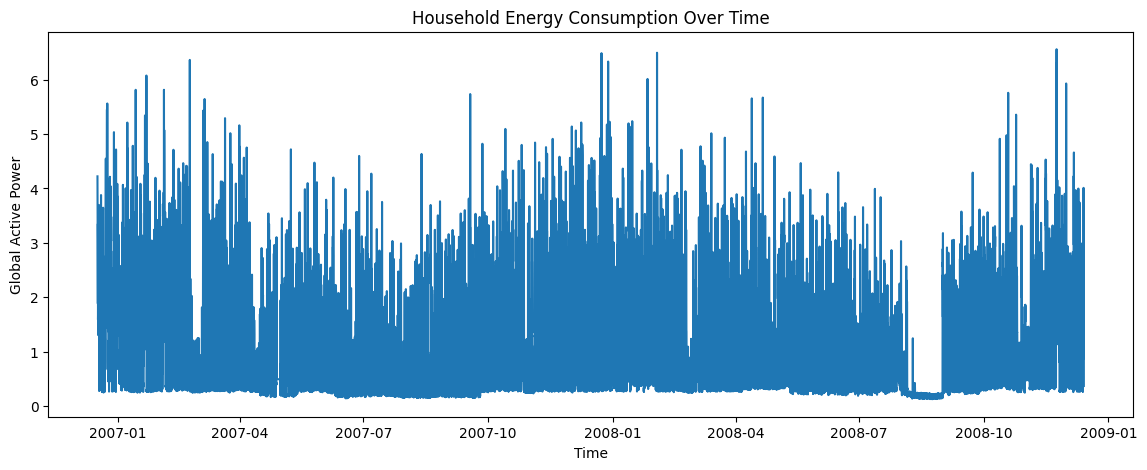

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(energy)
plt.title("Household Energy Consumption Over Time")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.show()


**Daily Pattern**

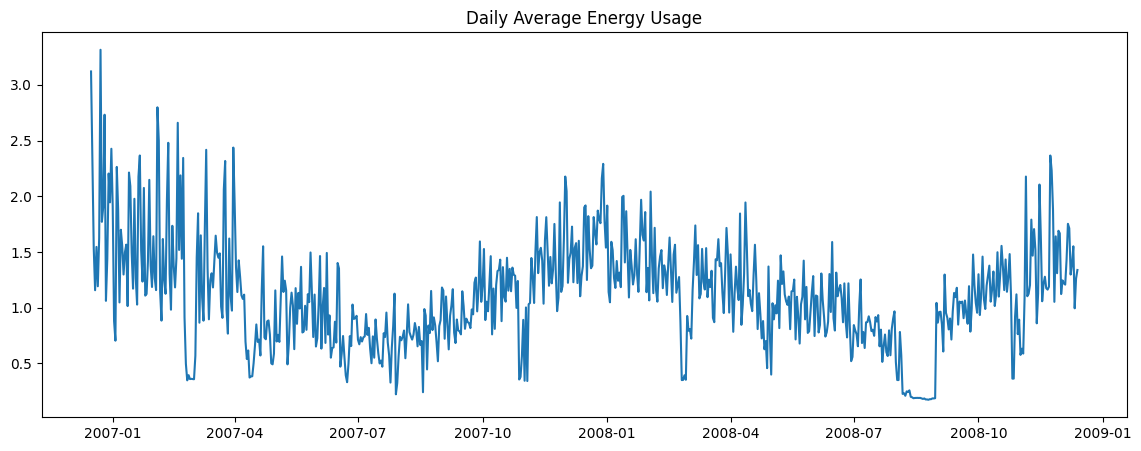

In [ ]:
energy_daily = energy.resample('D').mean()

plt.figure(figsize=(14,5))
plt.plot(energy_daily)
plt.title("Daily Average Energy Usage")
plt.show()


##5. Feature Preparation
**Feature Engineering**

Time-based features for machine learning models like XGBoost

In [ ]:
df_feat = energy.to_frame(name='energy')

df_feat['hour'] = df_feat.index.hour
df_feat['dayofweek'] = df_feat.index.dayofweek
df_feat['month'] = df_feat.index.month
df_feat['is_weekend'] = df_feat['dayofweek'].apply(lambda x: 1 if x>=5 else 0)


**Train Test Split**

We use last 20% as test

In [ ]:
split = int(len(df_feat)*0.8)

train = df_feat.iloc[:split]
test = df_feat.iloc[split:]


##6. Model Training and Testing
###**MODEL 1 — ARIMA**
ARIMA (AutoRegressive Integrated Moving Average) is a statistical time series model that predicts future values based on past observations and trends. It combines autoregression (AR), differencing (I) to make data stationary, and moving average (MA) of residual errors.

**Train ARIMA**

In [ ]:
model_arima = ARIMA(train['energy'], order=(2,1,2))
model_arima_fit = model_arima.fit()

forecast_arima = model_arima_fit.forecast(steps=len(test))


**Evaluation**

In [ ]:
mae_arima = mean_absolute_error(test['energy'], forecast_arima)
rmse_arima = math.sqrt(mean_squared_error(test['energy'], forecast_arima))

print("ARIMA MAE:", mae_arima)
print("ARIMA RMSE:", rmse_arima)


ARIMA MAE: 0.6816911502916182
ARIMA RMSE: 0.9085331518983429


###**MODEL 2 — PROPHET**
Prophet is a decomposition-based forecasting model that separates time series into trend, seasonality, and holidays/events. It is designed to handle daily, weekly, and yearly patterns automatically.


**Prepare data for Prophet**

In [ ]:
prophet_df = energy.reset_index()
prophet_df.columns = ['ds','y']

train_p = prophet_df.iloc[:split]
test_p = prophet_df.iloc[split:]


**Train**

In [ ]:
model_prophet = Prophet()
model_prophet.fit(train_p)

future = model_prophet.make_future_dataframe(periods=len(test_p), freq='H')
forecast_prophet = model_prophet.predict(future)

forecast_values = forecast_prophet['yhat'].iloc[-len(test_p):].values


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


**Evaluation**

In [ ]:
mae_prophet = mean_absolute_error(test_p['y'], forecast_values)
rmse_prophet = math.sqrt(mean_squared_error(test_p['y'], forecast_values))

print("Prophet MAE:", mae_prophet)
print("Prophet RMSE:", rmse_prophet)


Prophet MAE: 0.7082535395535247
Prophet RMSE: 0.9434633770241485


###**MODEL 3 — XGBoost**

XGBoost is a gradient boosting machine learning model that builds an ensemble of decision trees. By using time-based features like hour, day of the week, and weekend indicators, it can learn complex patterns in the data.

**Prepare Features**

In [ ]:
X_train = train.drop('energy', axis=1)
y_train = train['energy']

X_test = test.drop('energy', axis=1)
y_test = test['energy']


**Train**

In [ ]:
model_xgb = XGBRegressor(n_estimators=200, learning_rate=0.05)
model_xgb.fit(X_train, y_train)

forecast_xgb = model_xgb.predict(X_test)


**Evaluation**

In [ ]:
mae_xgb = mean_absolute_error(y_test, forecast_xgb)
rmse_xgb = math.sqrt(mean_squared_error(y_test, forecast_xgb))

print("XGBoost MAE:", mae_xgb)
print("XGBoost RMSE:", rmse_xgb)


XGBoost MAE: 0.525615497670022
XGBoost RMSE: 0.7196272184158473


###**Model Comparison**

In [ ]:
results = pd.DataFrame({
    'Model':['ARIMA','Prophet','XGBoost'],
    'MAE':[mae_arima, mae_prophet, mae_xgb],
    'RMSE':[rmse_arima, rmse_prophet, rmse_xgb]
})

print(results)


     Model       MAE      RMSE
0    ARIMA  0.681691  0.908533
1  Prophet  0.708254  0.943463
2  XGBoost  0.525615  0.719627


**Actual vs Forecast Plot**

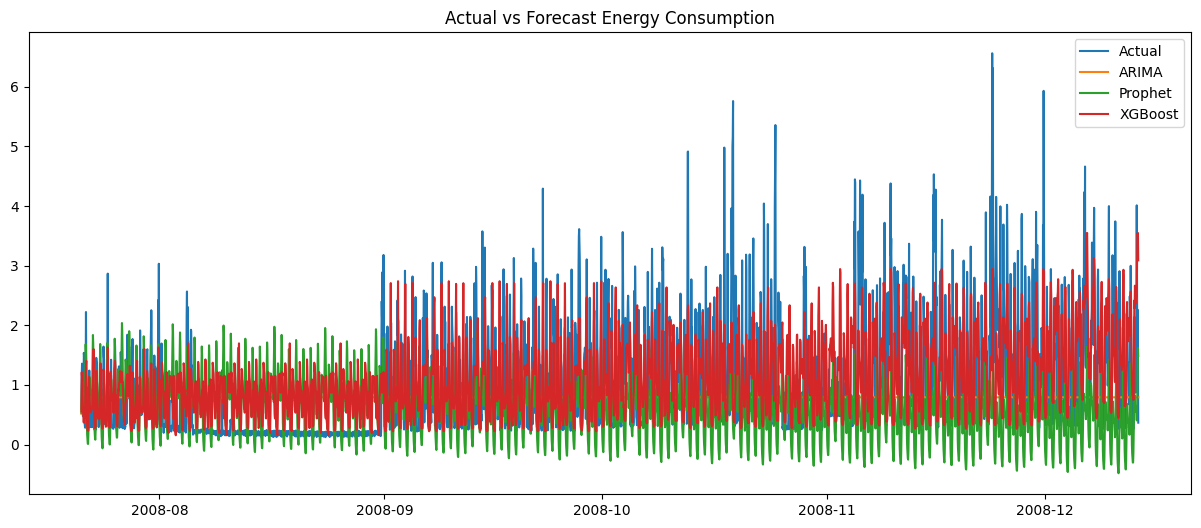

In [ ]:
plt.figure(figsize=(15,6))

plt.plot(test.index, test['energy'], label="Actual")
plt.plot(test.index, forecast_arima, label="ARIMA")
plt.plot(test.index, forecast_values, label="Prophet")
plt.plot(test.index, forecast_xgb, label="XGBoost")

plt.legend()
plt.title("Actual vs Forecast Energy Consumption")
plt.show()


##7. Conclusion and Insights

In this task, we forecasted short-term household energy consumption using historical time series data. Three models—**ARIMA**, **Prophet**, and **XGBoost**—were compared based on MAE and RMSE metrics.

**Key Insights:**

* **ARIMA** captures past trends well but struggles with sudden changes in energy usage.
* **Prophet** handles seasonal and weekly patterns better than ARIMA.
* **XGBoost** achieved the best performance by learning patterns from time-based features such as hour, day of the week, and weekend indicators.

**Conclusion:**
Machine learning models that include temporal feature engineering, like XGBoost, are most effective for short-term household energy forecasting. This approach can help households and energy providers plan and manage electricity usage efficiently.
